[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mlnoobs/mlops-project-study/blob/main/2022-05-30/training_remind_seminar.ipynb)

# 딥러닝 remind 세미나 1
taylor (2022-05-30)

- Linear(Fully-Connected layer), CNN(Convolutional neural network) 훈련 및 인퍼런스를 PyTorch를 사용해 google colab GPU에서 시도합니다.
- 노트북 제작에 있어 다음 레퍼런스를 많이 참고했습니다.
  - https://github.com/espnet/notebook/blob/master/tts_realtime_demo.ipynb
  - https://github.com/pytorch/examples/blob/main/mnist/main.py

## 필요 툴&라이브러리 설치

In [26]:
!pip install --upgrade pip
!pip install torch
!pip install torchvision
!pip install numpy
!pip install matplotlib
!pip install opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 MB 4.1 MB/s eta 0:00:00m eta 0:00:010:00:01


## import & 버전 확인

In [27]:
!python --version
!nvidia-smi
import torch
import torch.nn.functional as F
import numpy as np
import torchvision
from matplotlib import pyplot as plt
import time
print(torch.__version__)
print(np.__version__)
print(torchvision.__version__)


Python 3.8.8
zsh:1: command not found: nvidia-smi
1.11.0
1.20.1
0.12.0


## Hyperpatemerers 등 configs 세팅

In [28]:
# 훈련 결과 재현을 위한 seed값 고정
seed = '202205281708'
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 1e-2
n_epochs = 10
batch_size = 512

print("device:", device)
print("- gpu를 사용할 수 있는 환경이면 \'cuda\', 그렇지 않으면 \'cpu\'를 사용합니다.")
print("lr:", lr)
print("- learning rate는 이번 훈련으로 얻어낸 gradients를 얼마만큼의 강도로 모델 업데이트에 반영할지를 결정합니다.")
print("n_epochs:", n_epochs)
print("- epoch의 횟수는 전체 데이터셋을 몇 번 반복해서 훈련할 것인지를 결정합니다.")
print("batch_size:", batch_size)
print("- 훈련 시 mini-batch의 사이즈를 결정합니다.")
print("- SGD(stochastic gradient descent) 기반의 optimizer를 사용한다면,")
print("- 전체 데이터셋을 자그마한 mini-batch로 나누어서 순차적으로 훈련에 사용하게 됩니다.")
print("- 보통 클수록 보다 성능을 높이는 방향으로 훈련될 가능성이 높지만 메모리를 많이 차지하게 됩니다.")

device: cpu
- gpu를 사용할 수 있는 환경이면 'cuda', 그렇지 않으면 'cpu'를 사용합니다.
lr: 0.01
- learning rate는 이번 훈련으로 얻어낸 gradients를 얼마만큼의 강도로 모델 업데이트에 반영할지를 결정합니다.
n_epochs: 10
- epoch의 횟수는 전체 데이터셋을 몇 번 반복해서 훈련할 것인지를 결정합니다.
batch_size: 512
- 훈련 시 mini-batch의 사이즈를 결정합니다.
- SGD(stochastic gradient descent) 기반의 optimizer를 사용한다면,
- 전체 데이터셋을 자그마한 mini-batch로 나누어서 순차적으로 훈련에 사용하게 됩니다.
- 보통 클수록 보다 성능을 높이는 방향으로 훈련될 가능성이 높지만 메모리를 많이 차지하게 됩니다.


## 공개 데이터셋 다운로드: MNIST
torchvision 라이브러리를 사용하면 공개 데이터셋을 편리하게 다운로드받고, torch tensor 자료형으로 불러올 수 있습니다.

len(train_data): 60000
len(test_data): 10000
shape: torch.Size([1, 28, 28])
label: 3
maxval: tensor(2.8215)
minval: tensor(-0.4242)
mean of all training dataset: tensor(-0.0001)
var of all training dataset: tensor(1.0001)


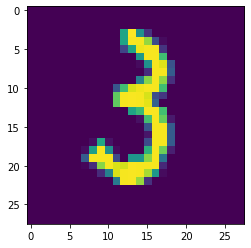

In [64]:
# torchvision 라이브러리를 사용해 MNIST 데이터셋 다운로드 및 전처리
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)) # MNIST 데이터셋의 평균과 표준편차
            ])
train_data = torchvision.datasets.MNIST('./mnist_dataset', train=True, download=True,
                            transform=transform)
test_data = torchvision.datasets.MNIST('./mnist_dataset', train=False, download=True,
                            transform=transform)
print('len(train_data):', len(train_data))
print('len(test_data):', len(test_data))

# 데이터 정보를 확인해봅시다.
sample = train_data[1234]
print('shape:', sample[0].shape)
print('label:', sample[1])
print('maxval:', torch.max(sample[0]))
print('minval:', torch.min(sample[0]))
train_data_without_labels = torch.stack([s[0] for s in train_data])
print('mean of all training dataset:', torch.mean(train_data_without_labels))
print('var of all training dataset:', torch.var(train_data_without_labels))
plt.imshow(sample[0][0])
plt.show()

# torch의 DataLoader를 사용하면 데이터셋을 준비하는 과정이 편리합니다.
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=1000,
                                          shuffle=True)

## 훈련 & 테스트 코드

In [30]:
def train_model(model, device, train_loader, optimizer, n_epochs, fn_loss,
                log_interval=10000):
    model.train()
    for epoch in range(1, n_epochs + 1):
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = fn_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % (log_interval // len(data)) == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                      epoch, batch_idx * len(data), len(train_loader.dataset),
                      100. * batch_idx / len(train_loader), loss.item()))
            
def test_model(model, device, test_loader, fn_loss):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## inference 위해서 모델 저장 및 불러오는 방법
    1. 데이터 불러올 때 필요한 라이브러리들 불러오기
    2. 신경망을 구성하고 초기화하기
    3. 옵티마이저 초기화하기
    4. state_dict 을 통해 모델을 저장하고 불러오기
    5. 전체 모델을 저장하고 불러오기
        # 경로 지정
        PATH = "entire_model.pt"
        # 저장하기
        torch.save(net, PATH)
        # 불러오기
        model = torch.load(PATH)
        model.eval()
        
        
추론을 할때는 학습 단계에서 처럼 DataLoader를 활용할 필요 없음.
- 일반적으로 추론은 이미지가 1장씩 Input으로 들어가게 되기 때문이며, 미래에 획득할 이미지를 추론한다는 의미에서 Real-Time을 가정했을때 Batch단위로 들어갈 일이 없기 때문이다. (수집된 이미지를 저장해두었다가 추론하는 경우는 DataLoader를 활용하는것이 좋음)

## 예제 1: Linear layer 1개

In [31]:
class ModelV1(torch.nn.Module):
    def __init__(self):
        super(ModelV1, self).__init__()
        self.input_size = 28*28
        self.output_size = 10
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(self.input_size, self.output_size),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        for layer in self.layers:
            x = layer(x)
        output = F.log_softmax(x, dim=1)
        return output
    
print("loading ModelV1...") 
model = ModelV1().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
fn_loss = F.nll_loss
print("loaded ModelV1 to {}".format(device))
print(model)

loading ModelV1...
loaded ModelV1 to cpu
ModelV1(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [38]:
print('Number of model parameters: ', sum(param.numel() for param in model.parameters()))
print("device:", device)
print("lr:", lr)
print("n_epochs:", n_epochs)
print("batch_size:", batch_size)

t = time.perf_counter()
train_model(model, device, train_loader, optimizer, n_epochs, fn_loss, log_interval=60000)
test_model(model, device, test_loader, fn_loss)
print("Train/Eval done. elapsed: {} sec".format(time.perf_counter() - t))

Number of model parameters:  7850
device: cpu
lr: 0.01
n_epochs: 10
batch_size: 512
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.316617
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.319297
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.382666
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.294995
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.295121
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.242542
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.318029
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.299951
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.283152
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.283107

Test set: Average loss: 0.3216, Accuracy: 9099/10000 (91%)

Train/Eval done. elapsed: 60.15913430200089 sec


In [122]:
import cv2

def save_model(model, PATH):
    #PATH = "~/Documents/MLopsproject/mlops-project-study/2022-05-30/homework/model/model.pt"
    torch.save(model, PATH)
    
def load_model(PATH):
    model = torch.load(PATH)
    model.eval()
    return model
    
def classification_img(img_path, model):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    print(img)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # opencv는 BGR순서로 read한다.
    img = torch.from_numpy(img).float()
    #img = img.permute(2, 0, 1).squeeze(0) # (H, W, C) -> (C, H, W) -> (1, C, H, W)

    model = model.to(device)
    img = img.to(device)

    model.eval()    #nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수
    criterion = torch.nn.Softmax()
    out = model(img)
    label_idx = torch.argmax(out, dim=1)
    prob = criterion(out)

    return prob, label_idx


def inference_model(model,infer_img_dir):
    for img in os.scandir(infer_img_dir):
        img_path = os.path.join(infer_img_dir, img.name)

    pred, label_idx = classification_img(img_path, model)

    #label_name = label_map[label_idx]
    print(f'Prob of {label_name}: {100 * prob:.4f}%')
    
    
def inference_model_mnist_img(model, img):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    img = img.to(device)

    model.eval()    #nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수
    #criterion = torch.nn.Softmax()
    #prob = criterion(out)
    out = model(img)
    label_idx = torch.argmax(out, dim=1)

    print("inference : ", label_idx[0])
    #print(f'Prob of {label_name}: {100 * prob:.4f}%')

shape: torch.Size([1, 28, 28])
label: 3


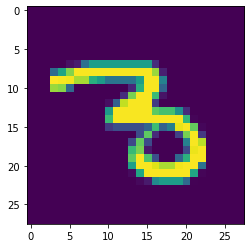

inference :  tensor(3)


In [123]:
import os
#save_model(model, "mnist-model.pt")
model = load_model("mnist-model.pt")

sample = train_data[30]
print('shape:', sample[0].shape)
print('label:', sample[1])

plt.imshow(sample[0][0])
plt.show()

inference_model_mnist_img(model, sample[0])
#inference_model(model,"/Users/ruby/Documents/MLopsproject/mlops-project-study/2022-05-30/homework/mnist_infer")

#del model
#del optimizer
#torch.cuda.empty_cache()

## 예제 2: Linear layer 3개

In [ ]:
class ModelV2(torch.nn.Module):
    def __init__(self):
        super(ModelV2, self).__init__()
        self.input_size = 28*28
        self.hidden_size = 256
        self.output_size = 10
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(self.input_size, self.hidden_size),
            torch.nn.Linear(self.hidden_size, self.hidden_size),
            torch.nn.Linear(self.hidden_size, self.output_size),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        for idx, layer in enumerate(self.layers):
            x = layer(x)
            x = F.relu(x) if idx != len(self.layers)-1 else x
        output = F.log_softmax(x, dim=1)
        return output

print("loading ModelV2...") 
model = ModelV2().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
fn_loss = F.nll_loss
print("loaded ModelV2 to {}".format(device))
print(model)
print('Number of model parameters: ', sum(param.numel() for param in model.parameters()))
print("device:", device)
print("lr:", lr)
print("n_epochs:", n_epochs)
print("batch_size:", batch_size)

t = time.perf_counter()
train_model(model, device, train_loader, optimizer, n_epochs, fn_loss, log_interval=60000)
test_model(model, device, test_loader, fn_loss)
print("Train/Eval done. elapsed: {} sec".format(time.perf_counter() - t))

del model
del optimizer
torch.cuda.empty_cache()

## 예제 3: CNN, linear, 각종 함수 마음껏

In [58]:
class ModelV3(torch.nn.Module):
    def __init__(self):
        super(ModelV3, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

print("loading ModelV3...") 
model = ModelV3().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
fn_loss = F.nll_loss
print("loaded ModelV3 to {}".format(device))
print(model)
print('Number of model parameters: ', sum(param.numel() for param in model.parameters()))
print("device:", device)
print("lr:", lr)
print("n_epochs:", n_epochs)
print("batch_size:", batch_size)

t = time.perf_counter()
train_model(model, device, train_loader, optimizer, n_epochs, fn_loss, log_interval=60000)
test_model(model, device, test_loader, fn_loss)

#save_model(model, "mnist-model3.pt")
#model = load_model("mnist-model3.pt")
#inference_model(model,"/Users/ruby/Documents/MLopsproject/mlops-project-study/2022-05-30/homework/mnist_infer")
#print("Train/Eval done. elapsed: {} sec".format(time.perf_counter() - t))

#del model
#del optimizer
torch.cuda.empty_cache()

loading ModelV3...
loaded ModelV3 to cpu
ModelV3(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Number of model parameters:  1199882
device: cpu
lr: 0.01
n_epochs: 10
batch_size: 512
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312362
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.716779
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.459728
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.450340
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.466849
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.281418
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.301595
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.302102
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.224618
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.338653

Test set: Average loss: 0.1525, Accuracy: 9549/10000 (95%)

None


TypeError: expected np.ndarray (got NoneType)

## 예제 4: ModelV3의 optimizer를 Adam으로 교체, LR decaying 적용

In [ ]:
from torch.optim.lr_scheduler import StepLR

def train_model_scheduler(model, device, train_loader, optimizer, n_epochs, fn_loss,
                          scheduler, log_interval=10000):
    model.train()
    for epoch in range(1, n_epochs + 1):
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = fn_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % (log_interval // len(data)) == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                      epoch, batch_idx * len(data), len(train_loader.dataset),
                      100. * batch_idx / len(train_loader), loss.item()))
        scheduler.step()


print("loading ModelV3...") 
model = ModelV3().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
fn_loss = F.nll_loss

print("loaded ModelV3 to {}".format(device))
print(model)
print('Number of model parameters: ', sum(param.numel() for param in model.parameters()))
print("device:", device)
print("lr:", lr)
print("n_epochs:", n_epochs)
print("batch_size:", batch_size)

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

t = time.perf_counter()
train_model_scheduler(model, device, train_loader, optimizer, n_epochs, fn_loss, scheduler, log_interval=60000)
test_model(model, device, test_loader, fn_loss)
print("Train/Eval done. elapsed: {} sec".format(time.perf_counter() - t))

del model
del optimizer
torch.cuda.empty_cache()

## 예제 5: 훈련 완료된 빅 모델 가져와서 전이 학습(transfer learning)
원래 ImageNet이라는 훨씬 큰 classification dataset에 맞춰서 훈련이 완료된 모델을 가져와서 MNIST 맞춤형으로 전이 학습을 시도



In [ ]:
# ref: https://ingu627.github.io/code/ResNet50_pytorch/
class MNISTBigModel(torch.nn.Module): # MnistResNet은 nn.Module 상속
    def __init__(self, in_channels=1):
        super(MNISTBigModel, self).__init__()

        # torchvision.models에서 사전훈련된 resnet 모델 가져오기
        self.model = torchvision.models.resnet50(pretrained=True)

        # 기본 채널이 3(RGB)이기 때문에 fashion_mnist에 맞게 1(grayscale image)로 바꿔준다.  
        # 원래 ResNet의 첫번째 층
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.conv1 = torch.nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
        # 1000개 클래스 대신 10개 클래스로 바꿔주기
        num_ftrs = self.model.fc.in_features
        #  nn.Linear(in_features, out_features ...)
        self.model.fc = torch.nn.Linear(num_ftrs, 10)
        #num_ftrs = self.model.fc.out_features
        #self.projection_layer = torch.nn.Linear(num_ftrs, 10)

    def forward(self, x): # 모델에 있는 foward 함수 그대로 가져오기
        #with torch.no_grad():
        x = self.model(x)
        #x = self.projection_layer(x)
        output = F.log_softmax(x, dim=1)
        return output

lr = 3e-6
n_epochs = 3
batch_size = 64

# MNIST 그림의 크기를 ImageNet 데이터와 맞추기 위해 데이터셋을 다시 로드
transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize((224, 224)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)) # MNIST 데이터셋의 평균과 표준편차
            ])
train_data = torchvision.datasets.MNIST('./mnist_dataset', train=True, download=True,
                            transform=transform)
test_data = torchvision.datasets.MNIST('./mnist_dataset', train=False, download=True,
                            transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=10,
                                          shuffle=True)

print("loading MNISTBigModel...") 
model = MNISTBigModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
fn_loss = F.nll_loss

print("loaded MNISTBigModel to {}".format(device))
print(model)
print('Number of model parameters: ', sum(param.numel() for param in model.parameters()))
print("device:", device)
print("lr:", lr)
print("n_epochs:", n_epochs)
print("batch_size:", batch_size)

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

t = time.perf_counter()
train_model_scheduler(model, device, train_loader, optimizer, n_epochs, fn_loss, scheduler, log_interval=10000)
test_model(model, device, test_loader, fn_loss)
print("Train/Eval done. elapsed: {} sec".format(time.perf_counter() - t))

del model
del optimizer
torch.cuda.empty_cache()

loading MNISTBigModel...
loaded MNISTBigModel to cuda
MNISTBigModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(